In [2]:
import os
import numpy as np
import data.data_selector as ds
import utils.plot_functions as pf
import utils.data_processing as dp
import models.model_picker as mp
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from data.dataset import Dataset
import pickle
import imageio
import copy
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = [15,15]

In [5]:
idx=1

In [110]:
with np.load('/media/tbell/sanborn/rd_analysis/inputs/vh_test_lpf2.npz') as d:
    data = d['arr_0'].item()['train'].images

In [111]:
np.min(data)

-0.30017053478390326

In [112]:
np.max(data)

0.14762800061362719

## Data preprocessing for model comparisons
1. Center whole images
2. Lowpass filter whole images
3. Whiten whole images (for LCA only)
4. Patch

In [6]:
def plot_amplitude_spectrum(images, idx):
    cmap=plt.get_cmap("viridis")
    c_norm = matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.01)
    plt.imshow(np.sqrt(np.real(images[idx])**2 + np.imag(images[idx])**2), cmap=cmap, norm=c_norm)

In [7]:
def psnr(orig_img, recon):
    data_range = np.max(orig_img) - np.min(orig_img)
    error = np.mean((orig_img - recon) **2)
    psnr = np.mean(10 * np.log10(data_range ** 2 / error))
    return psnr


In [8]:
def preprocess(data, params):
    """
    Center, LPF, and/or whiten data
    """    
    flatten=False
    (data, orig_shape, num_examples, num_rows) = dp.reshape_data(data, flatten)[0:4]
    data_proc, data_mean = dp.center_data(data)
    filt = np.identity(data_proc.shape[1])
    if params["pad_b4_fft"]:
        N = np.int(2**(np.ceil(np.log2(params["img_edge_size"]*2))))
    else:
        N = params["img_edge_size"]
    data_proc = np.fft.fftshift(np.fft.fft2(data_proc.squeeze(), s=[N,N], axes=(1,2)), axes=(1,2))   
    nyq = np.int32(np.floor(num_rows/2))
    freqs = np.linspace(-N/2, (N/2)-1, num=N)
    fspace = np.meshgrid(freqs, freqs)
    rho = np.sqrt(np.square(fspace[0]) + np.square(fspace[1]))
    lpf = np.exp(-0.5 * np.square(rho / (0.7 * N)))
    if params["lpf_data"]:
        filt = lpf     
    elif params["whiten_data"]:
        filt = np.multiply(rho, lpf) # filter is in the frequency domain
    data_proc = np.multiply(data_proc, filt)
    data_proc = np.real(np.fft.ifft2(np.fft.ifftshift(data_proc.squeeze(), axes=(1,2)), axes=(1,2)))
    if data.shape != orig_shape:
        data_proc = dp.reshape_data(data_proc, not flatten, out_shape=orig_shape[1:])[0]
    if "crop_border" in params and params["crop_border"] is not None:
        imsize = params["img_edge_size"] - params["crop_border"]
    else: 
        imsize = params["img_edge_size"]
    data_proc = data_proc[:, :imsize, :imsize, None]
    data_proc = dp.reshape_data(data_proc, flatten=False)[0]
    return data_proc, data_mean, filt

In [9]:
def gen_dataset(images, params) :
    dataset = Dataset(copy.deepcopy(images), lbls=None, ignore_lbls=None)
    data = {"train": dataset}
    whole_images, data['train'].data_mean, data['train'].w_filter = preprocess(copy.deepcopy(images), params)
    out_shape = (int(params["num_patches"]), int(params["patch_edge_size"]),
      int(params["patch_edge_size"]), data['train'].num_channels)
    data['train'].num_examples = out_shape[0]
    data['train'].reset_counters()
    data['train'].images = dp.extract_patches(whole_images, out_shape, overlapping=params["overlapping_patches"], randomize=params["randomize_patches"], var_thresh=params["var_thresh"],
      rand_state=np.random.RandomState())
    data['train'].shape = data['train'].images.shape
    data['train'].num_rows = data['train'].shape[1]
    data['train'].num_cols = data['train'].shape[2]
    data['train'].num_channels = data['train'].shape[3]
    data['train'].num_pixels = np.prod(data['train'].shape[1:])
    data['train'].images = dp.reshape_data(data['train'].images, True)[0]
    data['train'].shape = data['train'].images.shape
    data['train'].ndim = data['train'].images.ndim
    return data, whole_images

# Test sets (tiled patches)

## FT Whitened

In [11]:
params = {
  "data_type": "vanHateren",
  "num_images": 25,
  "extract_patches": True,
  "patch_edge_size": 16,
  "img_edge_size": 1024,
  "num_patches": 992000,
  "crop_border": None,
  "pad_b4_fft": False,
  "overlapping_patches": False,
  "randomize_patches": False,
  "var_thresh": 0,
  "lpf_data": False,
  "whiten_data": False,
  "whiten_method": "FT",
  "data_dir": "/media/tbell/datasets"
}

In [12]:
data = ds.get_data(params)

In [13]:
images = data['train'].images

In [95]:
blank = np.zeros((25, 1024, 1024, 1))

In [96]:
blank[:, :1024-32, :1024-32, :] = 1

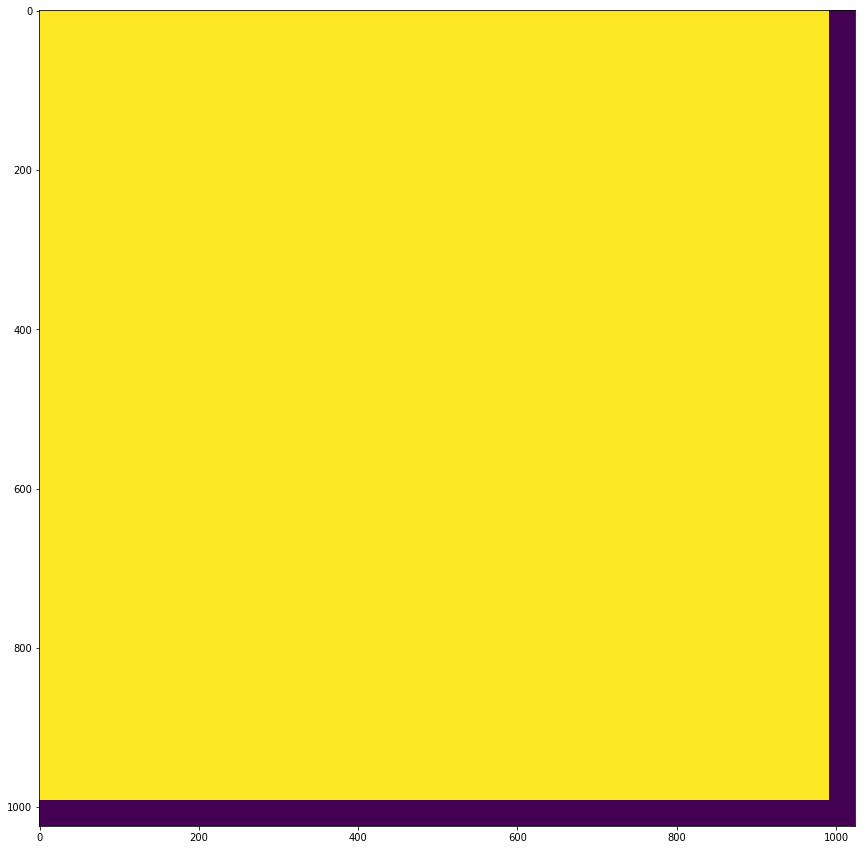

In [97]:
plt.imshow(blank[1].squeeze())

In [98]:
out_shape = (int(params["num_patches"]), int(params["patch_edge_size"]),
  int(params["patch_edge_size"]), data['train'].num_channels)
patched = dp.extract_patches(blank, out_shape, overlapping=params["overlapping_patches"], randomize=params["randomize_patches"], var_thresh=params["var_thresh"],
  rand_state=np.random.RandomState())

In [99]:
patched = dp.reshape_data(patched, flatten=True)[0]

In [100]:
x = np.where(patched[:4096, 0] == 0)[0]

In [101]:
x

array([  62,   63,  126,  127,  190,  191,  254,  255,  318,  319,  382,
        383,  446,  447,  510,  511,  574,  575,  638,  639,  702,  703,
        766,  767,  830,  831,  894,  895,  958,  959, 1022, 1023, 1086,
       1087, 1150, 1151, 1214, 1215, 1278, 1279, 1342, 1343, 1406, 1407,
       1470, 1471, 1534, 1535, 1598, 1599, 1662, 1663, 1726, 1727, 1790,
       1791, 1854, 1855, 1918, 1919, 1982, 1983, 2046, 2047, 2110, 2111,
       2174, 2175, 2238, 2239, 2302, 2303, 2366, 2367, 2430, 2431, 2494,
       2495, 2558, 2559, 2622, 2623, 2686, 2687, 2750, 2751, 2814, 2815,
       2878, 2879, 2942, 2943, 3006, 3007, 3070, 3071, 3134, 3135, 3198,
       3199, 3262, 3263, 3326, 3327, 3390, 3391, 3454, 3455, 3518, 3519,
       3582, 3583, 3646, 3647, 3710, 3711, 3774, 3775, 3838, 3839, 3902,
       3903, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975,
       3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986,
       3987, 3988, 3989, 3990, 3991, 3992, 3993, 39

In [103]:
y = [(64-1) + 64 * x for x in range(64-1)] + list(range(4096-64, 4096))

In [102]:
z = [(64-2) + 64 * x for x in range(64-2)] + list(range(4096-128, 4096))

In [94]:
len(y)

127

In [73]:
4095 - 4031

64

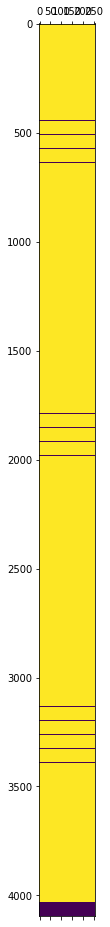

In [46]:
plt.matshow(patched[:4096])

In [ ]:
np.mean(images)

In [ ]:
np.min(images)

In [ ]:
np.max(images)

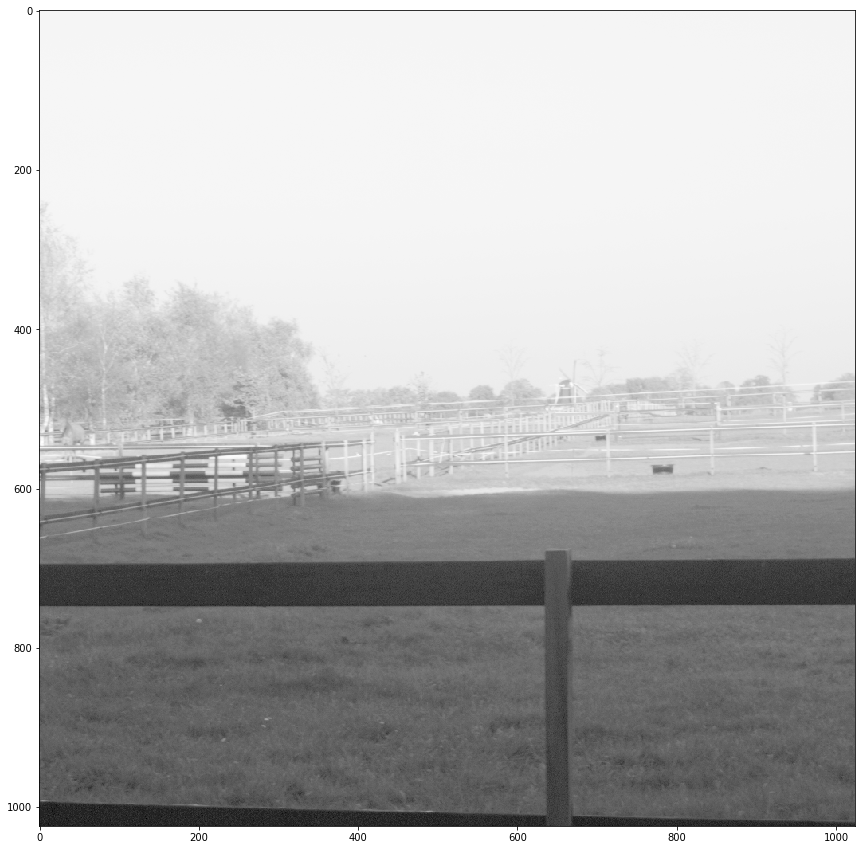

In [41]:
plt.imshow(images[idx].squeeze(), cmap="Greys_r")

In [48]:
data_white, white_whole_images = gen_dataset(images, params)

In [49]:
np.mean(white_whole_images)

0.014517155283221461

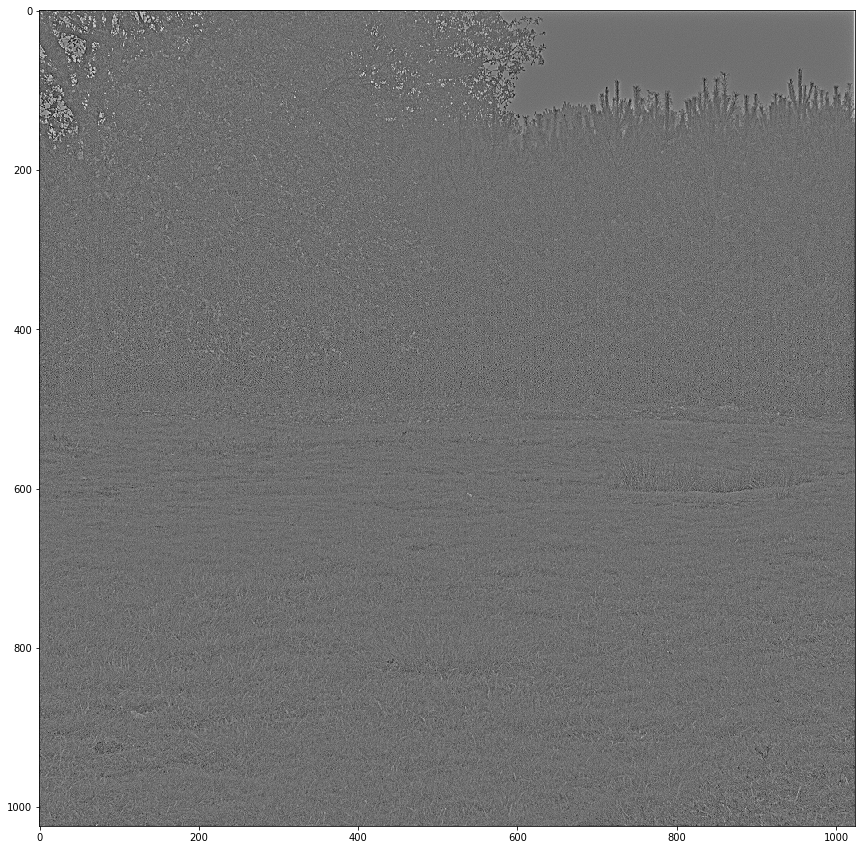

In [31]:
plt.imshow(np.reshape(white_whole_images[3], (1024,1024)), cmap="Greys_r")

In [98]:
plt.imshow(np.reshape(white_whole_images[idx], (1024,1024)), cmap="Greys_r")

In [99]:
np.min(white_whole_images)

-30.782841510707705

In [100]:
np.max(white_whole_images)

29.078330579353608

In [ ]:
np.mean(white_whole_images)

In [ ]:
pf.plot_data_tiled(data_white['train'].images[:25]);

In [ ]:
patch_to_image = dp.patches_to_image(dp.reshape_data(data_white['train'].images, flatten=False)[0], white_whole_images.shape)

In [ ]:
plt.imshow(patch_to_image[idx].squeeze(), cmap="Greys_r")

In [ ]:
unwhite = dp.unwhiten_data(patch_to_image, data_white['train'].data_mean)

In [ ]:
plt.imshow(unwhite[idx].squeeze(), cmap="Greys_r")

In [ ]:
np.mean((images - unwhite)**2)

## LPF 

In [205]:
params = {
  "data_type": "vanHateren",
  "num_images": 25,
  "extract_patches": True,
  "patch_edge_size": 16,
  "num_patches": 102400,
  "overlapping_patches": False,
  "randomize_patches": False,
  "var_thresh": 0,
  "lpf_data": True,
  "whiten_data": False,
  "data_dir": "/media/tbell/datasets"
}

In [206]:
data_lpf, lpf_whole_images = gen_dataset(images, params)

In [207]:
np.min(lpf_whole_images)

-0.21637938252599498

In [208]:
np.max(lpf_whole_images)

0.14790654418871771

In [209]:
np.mean(lpf_whole_images)

4.4581443035210537e-08

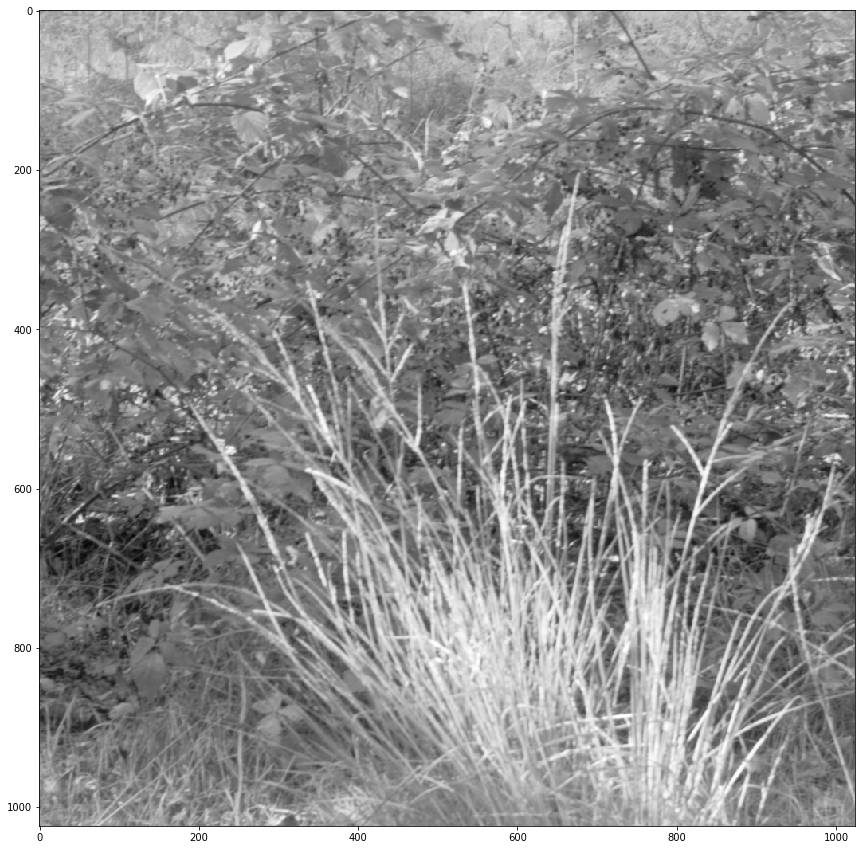

In [210]:
plt.imshow(np.reshape(lpf_whole_images[idx], (1024,1024)), cmap="Greys_r")

In [211]:
pf.plot_data_tiled(data_lpf['train'].images[:25]);

In [212]:
patch_to_image_lpf = dp.patches_to_image(dp.reshape_data(data_lpf['train'].images, flatten=False)[0], lpf_whole_images.shape)

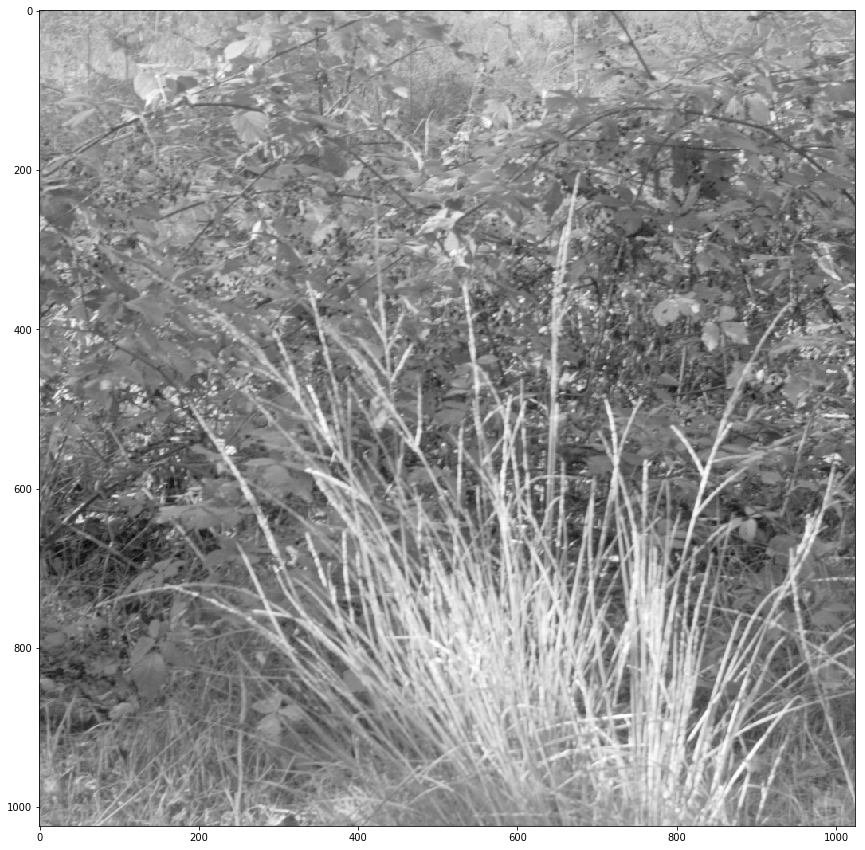

In [213]:
plt.imshow(images[idx].squeeze(), cmap="Greys_r")

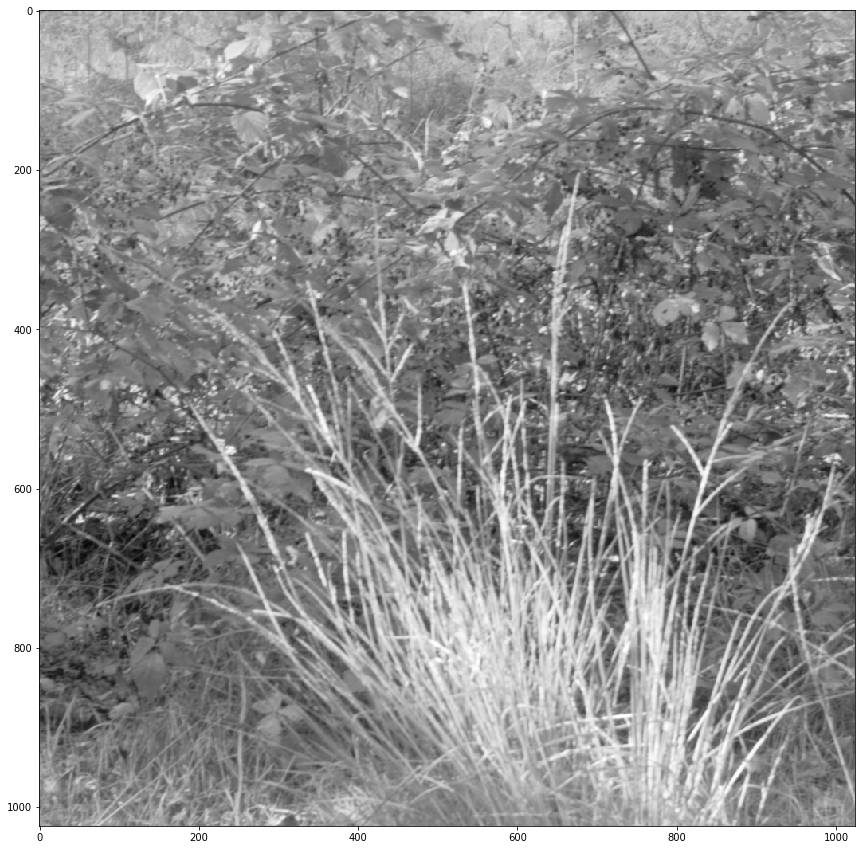

In [214]:
plt.imshow(patch_to_image_lpf[idx].squeeze(), cmap="Greys_r")

In [215]:
recon = patch_to_image_lpf + data_lpf['train'].data_mean

In [216]:
plt.imshow((dp.rescale_data_to_one(recon[idx]-images[idx])).squeeze(), cmap="Greys_r", vmin=0, vmax=1)
plt.colorbar()

In [217]:
np.mean((recon - images)**2)

9.5868063048618732e-06

In [190]:
ft_pspec = dp.phase_avg_pow_spec(white_whole_images)
avg_ft_pspec = np.mean(ft_pspec, axis=0)

pspec = dp.phase_avg_pow_spec(images)
avg_pspec = np.mean(pspec, axis=0)

lpf_pspec = dp.phase_avg_pow_spec(lpf_whole_images)
avg_lpf_pspec = np.mean(lpf_pspec, axis=0)

(fig, ax) = plt.subplots(1)
ax.loglog(range(avg_pspec.shape[0]), avg_pspec, 'k', label="original")
ax.loglog(range(avg_ft_pspec.shape[0]), avg_ft_pspec, 'r', label="FT")
ax.loglog(range(avg_lpf_pspec.shape[0]), avg_lpf_pspec, 'b', label="LPF")
ax.set_ylim([10**-4, 10**10])
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=12, ncol=4,
  borderaxespad=0., bbox_to_anchor=[0, -0.1], fancybox=True, loc="upper left")
plt.show()

KeyboardInterrupt: 

In [30]:
# np.savez("/media/tbell/sanborn/rd_analysis/inputs/vh_test_ftwhite2.npz", data_white)

In [31]:
# np.savez("/media/tbell/sanborn/rd_analysis/inputs/vh_test_lpf2.npz", data_lpf)

# Training (1 mil overlapping patches)

## FT White

In [32]:
params = {
  "data_type": "vanHateren",
  "num_images": 100,
  "extract_patches": True,
  "patch_edge_size": 16,
  "num_patches": 1000000,
  "overlapping_patches": True,
  "randomize_patches": True,
  "var_thresh": 0,
  "lpf_data": False,
  "whiten_data": True,
  "whiten_method": "FT",
  "data_dir": "/media/tbell/datasets"
}

In [33]:
data = ds.get_data(params)

In [34]:
images = data['train'].images

In [35]:
np.mean(images)

0.85598886

In [36]:
np.min(images)

0.5882715

In [37]:
np.max(images)

1.0

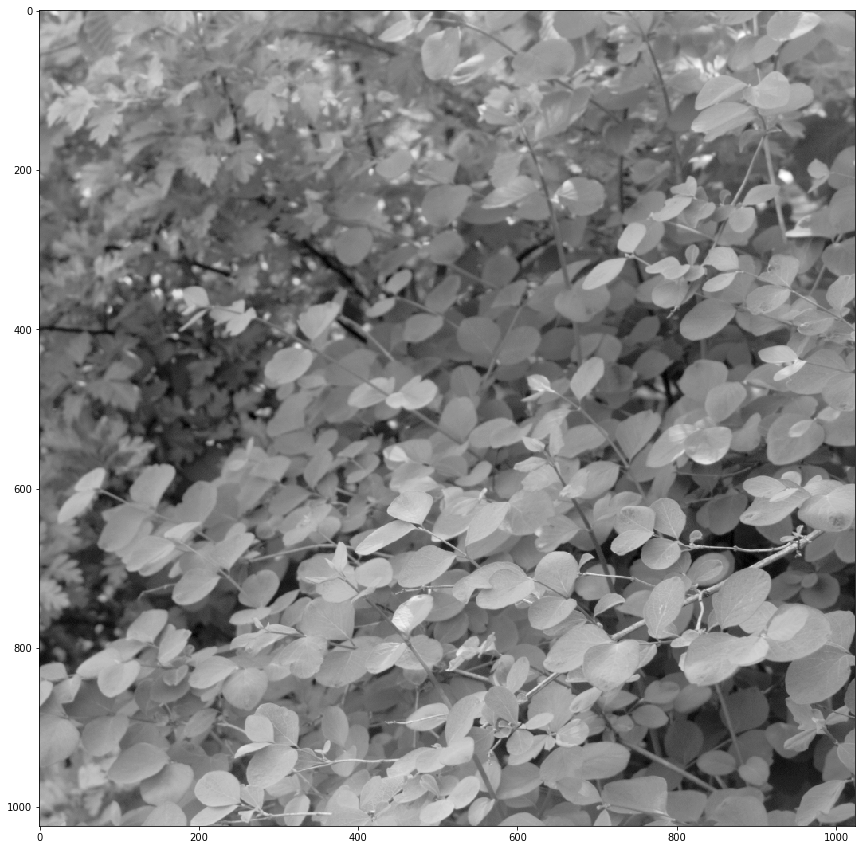

In [38]:
plt.imshow(images[idx].squeeze(), cmap="Greys_r")

In [39]:
data_white, white_whole_images = gen_dataset(images, params)

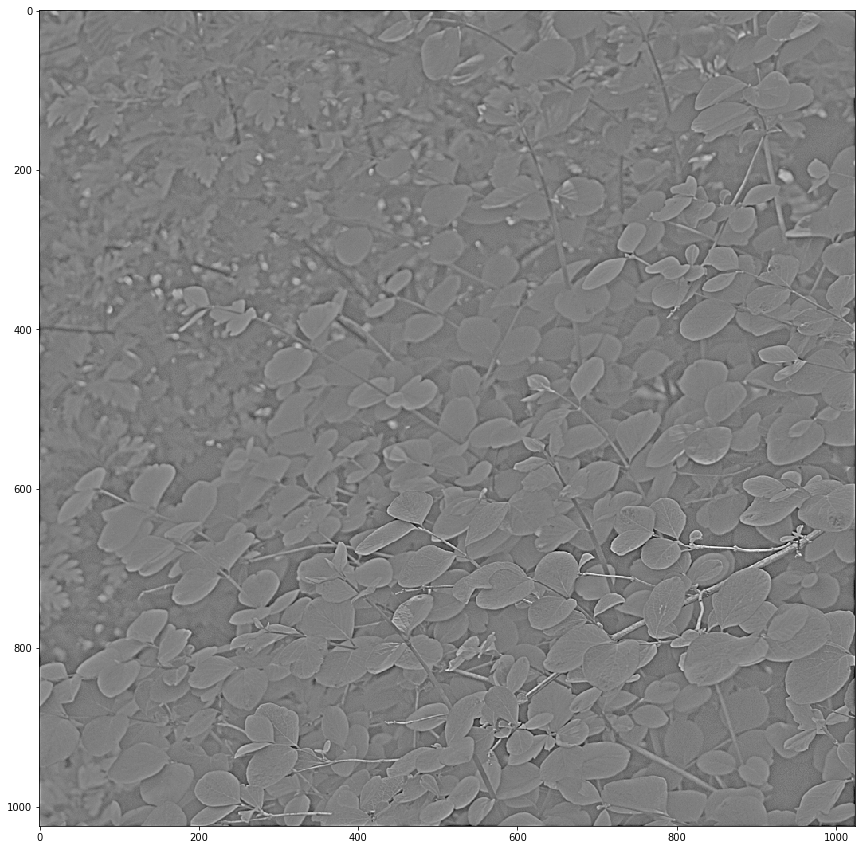

In [40]:
plt.imshow(np.reshape(white_whole_images[idx], (1024,1024)), cmap="Greys_r")

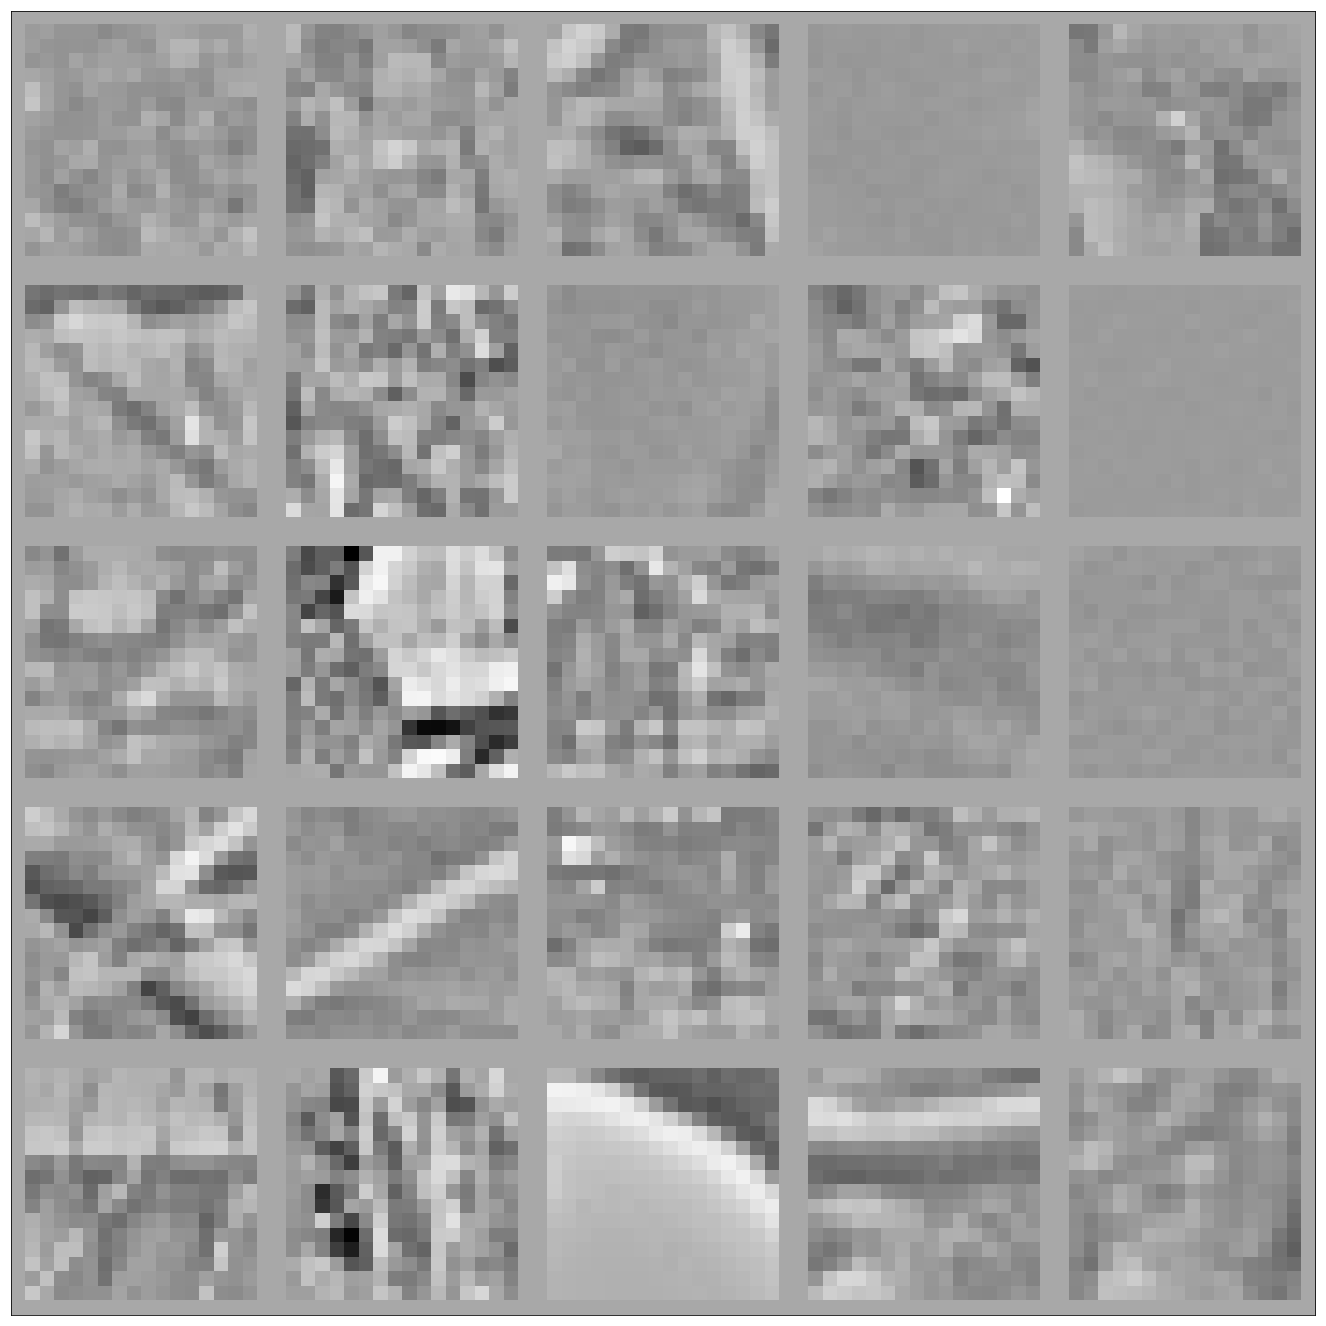

In [41]:
pf.plot_data_tiled(data_white['train'].images[:25]);

## LPF

In [42]:
params = {
  "data_type": "vanHateren",
  "num_images": 100,
  "extract_patches": True,
  "patch_edge_size": 16,
  "num_patches": 1000000,
  "overlapping_patches": True,
  "randomize_patches": True,
  "var_thresh": 0,
  "lpf_data": True,
  "whiten_data": False,
  "whiten_method": "FT",
  "data_dir": "/media/tbell/datasets"
}

In [43]:
data_lpf, lpf_whole_images = gen_dataset(images, params)

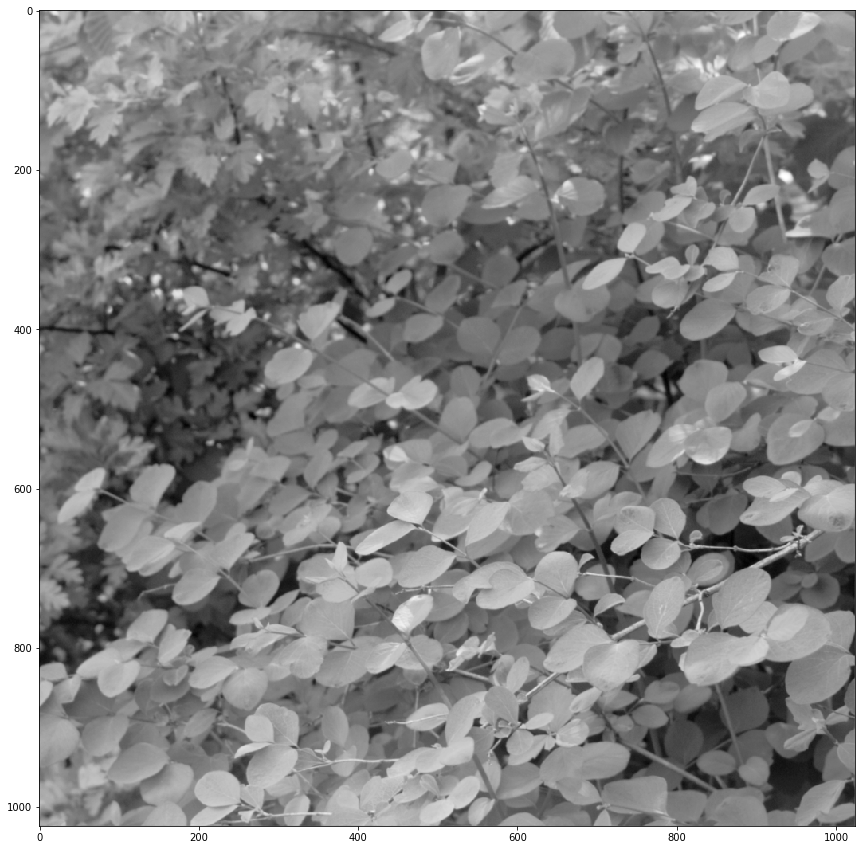

In [44]:
plt.imshow(np.reshape(lpf_whole_images[idx], (1024,1024)), cmap="Greys_r")

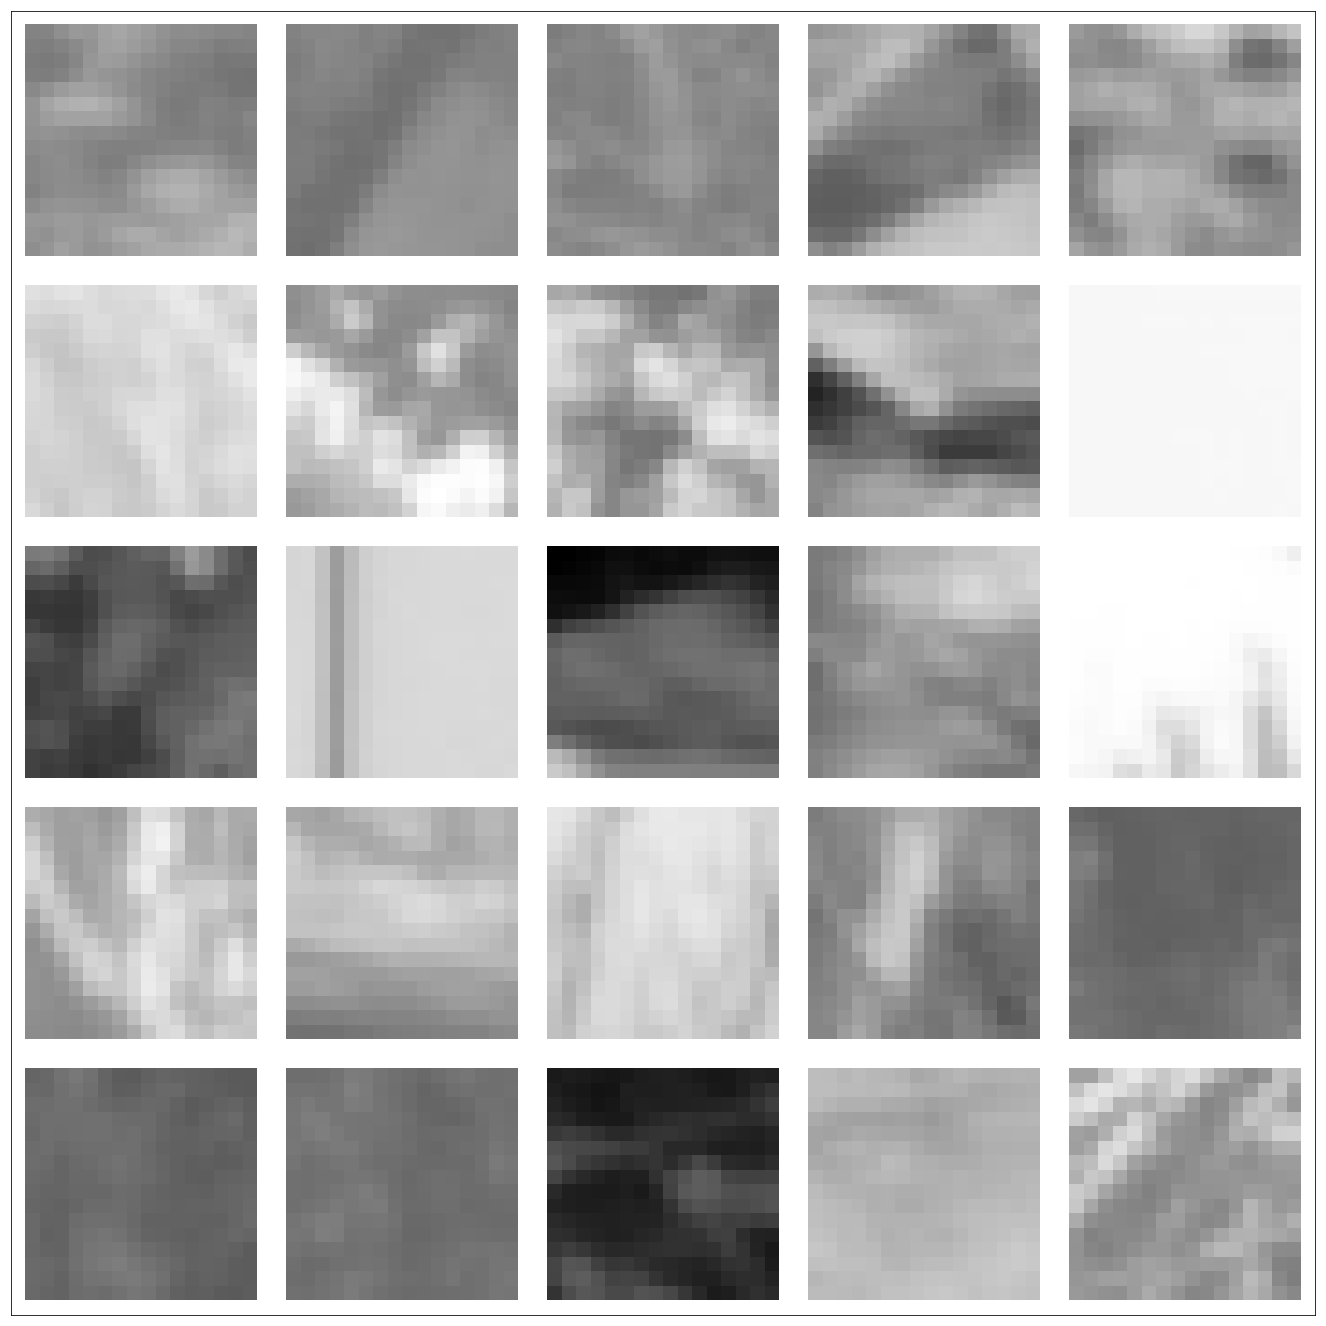

In [45]:
pf.plot_data_tiled(data_lpf['train'].images[:25]);

In [46]:
np.savez("/media/tbell/sanborn/rd_analysis/inputs/vh_train_ftwhite2.npz", data_white)

In [47]:
np.savez("/media/tbell/sanborn/rd_analysis/inputs/vh_train_lpf2.npz", data_lpf)